In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from scipy import stats
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# display warnings only the first time
import warnings
warnings.filterwarnings('ignore')

Importing both the datasets

In [3]:
# traffic station characteristics
traffic_station_df = pd.read_csv('/content/drive/MyDrive/Projects/OCBC/dot_traffic_stations_2015.txt.gz',
                                 header=0, sep=',', quotechar='"')

# traffic volume metrics associated to each traffic station
traffic_df = pd.read_csv('/content/drive/MyDrive/Projects/OCBC/dot_traffic_2015.txt.gz',
                         header=0, sep=',', quotechar='"')

# rename long feature names
traffic_station_df.rename(columns = {"number_of_lanes_in_direction_indicated": "lane_count"}, inplace = True)

# **CLEANING DATA - TRAFFIC DATA**

In [4]:
print('Traffic data:')
traffic_df.head()

Traffic data:


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,3,NaN,000084,4,3,2,4,43,78,116,144,132,115,150,184,169,136,129,89,122,124,110,69,73,28,12,6,15
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,3,NaN,056P94,381,252,218,194,220,348,453,679,826,962,1158,1379,1376,1383,1453,1617,1669,1308,1068,928,885,798,650,613,15
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,3,NaN,077590,585,408,328,364,696,1929,4228,5634,5673,4636,3925,3827,4049,3954,4077,4244,4405,4609,4361,3272,2243,2050,1453,892,15
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,3,NaN,450001,105,73,68,66,77,113,254,367,487,668,870,996,1003,1000,1043,1011,959,851,708,559,457,297,207,110,15
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,3,NaN,102210,6,4,2,3,1,10,17,52,64,68,82,96,99,87,87,83,61,55,35,29,21,23,9,7,15


We can see here that '**restrictions**' column is completely **empty** and therefore will be of no use to us.

In [5]:
traffic_df.isnull().mean()

date                                         0.0
day_of_data                                  0.0
day_of_week                                  0.0
direction_of_travel                          0.0
direction_of_travel_name                     0.0
fips_state_code                              0.0
functional_classification                    0.0
functional_classification_name               0.0
lane_of_travel                               0.0
month_of_data                                0.0
record_type                                  0.0
restrictions                                 1.0
station_id                                   0.0
traffic_volume_counted_after_0000_to_0100    0.0
traffic_volume_counted_after_0100_to_0200    0.0
traffic_volume_counted_after_0200_to_0300    0.0
traffic_volume_counted_after_0300_to_0400    0.0
traffic_volume_counted_after_0400_to_0500    0.0
traffic_volume_counted_after_0500_to_0600    0.0
traffic_volume_counted_after_0600_to_0700    0.0
traffic_volume_count

dropping **restrictions** column because it contains all values as null

In [6]:
# dropping restrictions column because it contains all values as null
traffic_df.dropna(how='all', axis=1, inplace=True)
traffic_df.reset_index(inplace=True, drop=True)

In [7]:
traffic_df.dtypes

date                                         object
day_of_data                                   int64
day_of_week                                   int64
direction_of_travel                           int64
direction_of_travel_name                     object
fips_state_code                               int64
functional_classification                    object
functional_classification_name               object
lane_of_travel                                int64
month_of_data                                 int64
record_type                                   int64
station_id                                   object
traffic_volume_counted_after_0000_to_0100     int64
traffic_volume_counted_after_0100_to_0200     int64
traffic_volume_counted_after_0200_to_0300     int64
traffic_volume_counted_after_0300_to_0400     int64
traffic_volume_counted_after_0400_to_0500     int64
traffic_volume_counted_after_0500_to_0600     int64
traffic_volume_counted_after_0600_to_0700     int64
traffic_volu

Changing the datatype of date column to datetime as the given datatype is not correct.

In [8]:
# Changing the datatype of date column to datetime as the given datatype is not correct.
traffic_df['date']= pd.to_datetime(traffic_df['date'], format='%Y-%m-%d')

# **Cleaning Data - Station data**

In [9]:
# view top of station dataframe
print('Traffic Station data:')
traffic_station_df.head()

Traffic Station data:


,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,fips_state_code,functional_classification,functional_classification_name,hpms_sample_identifier,hpms_sample_type,lane_of_travel,lane_of_travel_name,latitude,longitude,lrs_identification,lrs_location_point,method_of_data_retrieval,method_of_data_retrieval_name,method_of_traffic_volume_counting,method_of_traffic_volume_counting_name,method_of_truck_weighing,method_of_truck_weighing_name,method_of_vehicle_classification,method_of_vehicle_classification_name,national_highway_system,lane_count,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,primary_purpose_name,record_type,sample_type_for_traffic_volume,sample_type_for_traffic_volume_name,sample_type_for_truck_weight,sample_type_for_truck_weight_name,sample_type_for_vehicle_classification,sample_type_for_vehicle_classification_name,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,6,2U,Urban: Principal Arterial - Other Freeways or ...,NaN,N,4,Other lanes,33.850898,117.814391,00000000091R,NaN,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,5,5,0,0,3,091,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,6,3R,Rural: Principal Arterial - Other,NaN,N,1,Outside (rightmost) lane,37.874697,121.219590,00000000099R,248336.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,2,2,0,0,3,099,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,6,1R,Rural: Principal Arterial - Interstate,NaN,N,2,Other lanes,41.441777,122.435010,00000000005R,750293.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,3,Permanent vehicle classification device,Y,2,2,0,2,1,005,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,H,Station used for Heavy Vehicle Travel Informat...,N,NaN,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,49,1U,Urban: Principal Arterial - Interstate,A00015293910,Y,1,Outside (rightmost) lane,40.516500,111.891520,000000001500,290600.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),4,Portable weigh-in-motion system,3,Permanent vehicle classification device,Y,5,5,5,5,1,15,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,B,Station used for TMG sample and Strategic High...,N,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,34,1U,Urban: Principal Arterial - Interstate,NaN,N,4,Other lanes,40.892373,74.484206,NaN,NaN,2,Automated (telemetry),2,Portable traffic recording device,0,NaN,3,Permanent vehicle classification device,Y,4,4,4,4,1,000080,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,N,Station not used for any of the above,N,Station not used for Heavy Vehicle Travel Info

Here we are trying to observe the dataset so that we can clean it more efficiently

In [10]:
# we are dropping the columns with more than 60% NULL values as they will not be able to contribute in the dataset and will reduce the model accuracy
traffic_station_df.drop(['concurrent_signed_route_number', 'hpms_sample_identifier', 
                         'lrs_identification', 'lrs_location_point', 
                         'shrp_site_identification'], axis = 1, inplace=True)

# here we are only dropping the rows which contains the null values in 'latitude', 'longitude', 'station_location' because they contain 
# significatly less null values and are useful columns.
traffic_station_df.dropna(subset=['latitude', 'longitude', 'station_location'], inplace=True)
traffic_station_df.reset_index(inplace=True, drop=True)

In [11]:
print('Traffic_Station_Null_Mean: \n')
print(traffic_station_df.isnull().mean(), end = '\n\n')

print('Traffic_Station_Shape: \n')
print(traffic_station_df.shape, end = '\n\n')

Traffic_Station_Null_Mean: 

algorithm_of_vehicle_classification                 0.347580
algorithm_of_vehicle_classification_name            0.390847
calibration_of_weighing_system                      0.713170
calibration_of_weighing_system_name                 0.764985
classification_system_for_vehicle_classification    0.000000
concurrent_route_signing                            0.000000
direction_of_travel                                 0.000000
direction_of_travel_name                            0.000000
fips_county_code                                    0.000000
fips_state_code                                     0.000000
functional_classification                           0.000000
functional_classification_name                      0.000000
hpms_sample_type                                    0.000000
lane_of_travel                                      0.000000
lane_of_travel_name                                 0.000000
latitude                                            0.00

# **EDA - Traffic Data**    (Exploratory data analysis)


In [12]:
variables = ['traffic_volume_counted_after_0000_to_0100', 'traffic_volume_counted_after_0100_to_0200', 'traffic_volume_counted_after_0200_to_0300',
            'traffic_volume_counted_after_0300_to_0400', 'traffic_volume_counted_after_0400_to_0500', 'traffic_volume_counted_after_0500_to_0600',
             'traffic_volume_counted_after_0600_to_0700', 'traffic_volume_counted_after_0700_to_0800', 'traffic_volume_counted_after_0800_to_0900',
             'traffic_volume_counted_after_0900_to_1000', 'traffic_volume_counted_after_1000_to_1100', 'traffic_volume_counted_after_1100_to_1200',
             'traffic_volume_counted_after_1200_to_1300', 'traffic_volume_counted_after_1300_to_1400', 'traffic_volume_counted_after_1400_to_1500',
             'traffic_volume_counted_after_1500_to_1600', 'traffic_volume_counted_after_1600_to_1700', 'traffic_volume_counted_after_1700_to_1800',
             'traffic_volume_counted_after_1800_to_1900', 'traffic_volume_counted_after_1900_to_2000', 'traffic_volume_counted_after_2000_to_2100',
             'traffic_volume_counted_after_2100_to_2200', 'traffic_volume_counted_after_2200_to_2300', 'traffic_volume_counted_after_2300_to_2400']

# we will be starting by correcting the datatype of all the time-slots that are given to us, so that we will be able to sum them up very easily.
traffic_df[variables] = traffic_df[variables].astype(float).astype(int)

Here we are merging the time-slots in the **bucket of 4 hours** so that instead of dealing with 24 hours we will only have to deal with more accurate and less data.

In [13]:
till_4 = ['traffic_volume_counted_after_0000_to_0100', 'traffic_volume_counted_after_0100_to_0200', 'traffic_volume_counted_after_0200_to_0300',
         'traffic_volume_counted_after_0300_to_0400']
till_8 = ['traffic_volume_counted_after_0400_to_0500', 'traffic_volume_counted_after_0500_to_0600','traffic_volume_counted_after_0600_to_0700',
         'traffic_volume_counted_after_0700_to_0800']
till_12 = ['traffic_volume_counted_after_0800_to_0900','traffic_volume_counted_after_0900_to_1000', 'traffic_volume_counted_after_1000_to_1100',
          'traffic_volume_counted_after_1100_to_1200']
till_16 = ['traffic_volume_counted_after_1200_to_1300', 'traffic_volume_counted_after_1300_to_1400', 'traffic_volume_counted_after_1400_to_1500',
            'traffic_volume_counted_after_1500_to_1600']
till_20 = ['traffic_volume_counted_after_1600_to_1700', 'traffic_volume_counted_after_1700_to_1800','traffic_volume_counted_after_1800_to_1900',
           'traffic_volume_counted_after_1900_to_2000']
till_24 = ['traffic_volume_counted_after_2000_to_2100','traffic_volume_counted_after_2100_to_2200', 'traffic_volume_counted_after_2200_to_2300',
           'traffic_volume_counted_after_2300_to_2400']

# Here we are summing up the data of 4 hours and creating the new column with the new data that we have got after summing up.
traffic_df['1_to_4'] = traffic_df[till_4].sum(axis=1, numeric_only= True)
traffic_df['5_to_8'] = traffic_df[till_8].sum(axis=1, numeric_only= True)
traffic_df['9_to_12'] = traffic_df[till_12].sum(axis=1, numeric_only= True)
traffic_df['13_to_16'] = traffic_df[till_16].sum(axis=1, numeric_only= True)
traffic_df['17_to_20'] = traffic_df[till_20].sum(axis=1, numeric_only= True)
traffic_df['21_to_24'] = traffic_df[till_24].sum(axis=1, numeric_only= True)

# here we are dropping the columns named 'year_of_data', 'record_type' because they have only one value throughout the data which will affect our model accuracy.
traffic_df.drop(variables, axis = 1, inplace=True)
traffic_df.drop(['year_of_data', 'record_type'], axis = 1, inplace=True)
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,000084,13,381,581,523,425,119
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,056P94,1045,1700,4325,5829,4973,2946
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,077590,1685,12487,18061,16324,16647,6638
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,450001,312,811,3021,4057,3077,1071
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,102210,15,80,310,356,180,60


After creating bucket of 4 hours, here i am dividing the value of every **bucket by 4** so that out values does not explode and we only get the data of each hour relatively.

In [14]:
traffic_df['1_to_4'] = traffic_df['1_to_4'].div(4)
traffic_df['5_to_8'] = traffic_df['5_to_8'].div(4)
traffic_df['9_to_12'] = traffic_df['9_to_12'].div(4)
traffic_df['13_to_16'] = traffic_df['13_to_16'].div(4)
traffic_df['17_to_20'] = traffic_df['17_to_20'].div(4)
traffic_df['21_to_24'] = traffic_df['21_to_24'].div(4)
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,000084,3.25,95.25,145.25,130.75,106.25,29.75
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,056P94,261.25,425.00,1081.25,1457.25,1243.25,736.50
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,077590,421.25,3121.75,4515.25,4081.00,4161.75,1659.50
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,450001,78.00,202.75,755.25,1014.25,769.25,267.75
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,102210,3.75,20.00,77.50,89.00,45.00,15.00


From the below **boxplot**'s we can clearly see that there exists some **outliers in the dataset**. Therefore now we will be working on removing the outliers present in the data. 

> 1.   In statistics, an outlier is an observation point that is distant from other observations.
> 2.   In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.

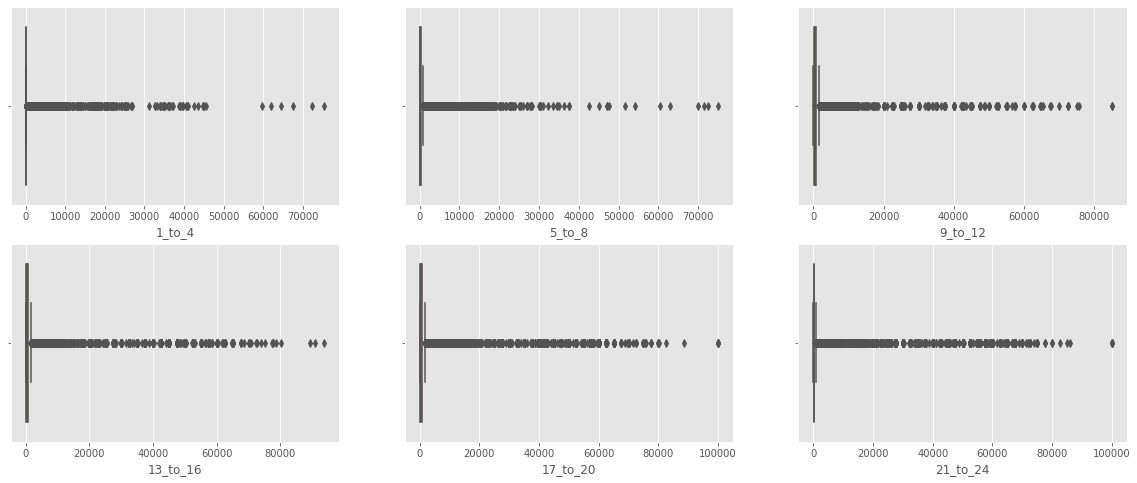

In [15]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
plt.figure(figsize = (20,8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    sns.boxplot(x=traffic_df[timings[i-1]])

For more detailed look we can see that **between hour 1 and 4** there exists many **outliers** and most of them are **above 3000 range**.

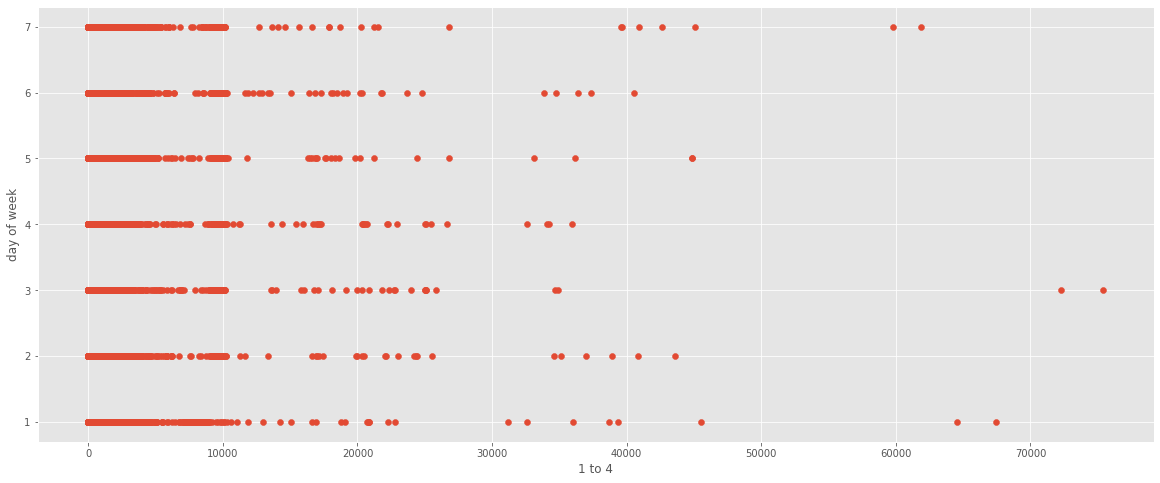

In [16]:
# For more detailed look we can see that between hour 1 and 4 there exists many outliers and most of them are above 3000 range.

fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(traffic_df['1_to_4'], traffic_df['day_of_week'])
ax.set_xlabel('1 to 4')
ax.set_ylabel('day of week')
plt.show()

Here we have used **Z-Score** to detect all the outliers present in the dataset.

The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.

**how does this help in identifying the outliers?**

> While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

We will use Z-score function defined in scipy library to detect the outliers.

1.   The **Z-score** is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

*I have taken the reference from [this article](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba) while detecting the outliers and removing them using Z-Score method.*

In [17]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
z = np.abs(stats.zscore(traffic_df[timings]))
print(z)
threshold = 3
print(np.where(z > 3))

[[0.35816073 0.38301916 0.49027821 0.53982261 0.52948674 0.36937989]
 [0.8088703  0.12299192 0.55500021 0.73811737 0.56247356 0.64209367]
 [1.53261048 4.26123421 4.38992123 3.26581811 3.36536376 1.96305596]
 ...
 [0.09304603 0.25956505 0.08093965 0.02103582 0.14989368 0.1110552 ]
 [2.07428476 7.20369443 6.02093525 5.27111933 4.72911366 2.94483291]
 [0.33441301 0.41447701 0.51400915 0.53982261 0.46033886 0.34004108]]
(array([      2,       2,       2, ..., 7140389, 7140389, 7140389]), array([1, 2, 3, ..., 2, 3, 4]))


In the below cell we are taking only the values which are between the range of **-3 to 3 in Z-Score**.

All other values are outliers.

In [18]:
traffic_df[timings] = traffic_df[timings][(z < 3).all(axis=1)]
traffic_df[timings] = traffic_df[timings][(-3 < z).all(axis=1)]
traffic_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

Now when we are running the boxplot again we can clearly see that all the outliers that were present in the dataset have been removed.

Hence we have now obtained a consistent and good performing dataset.

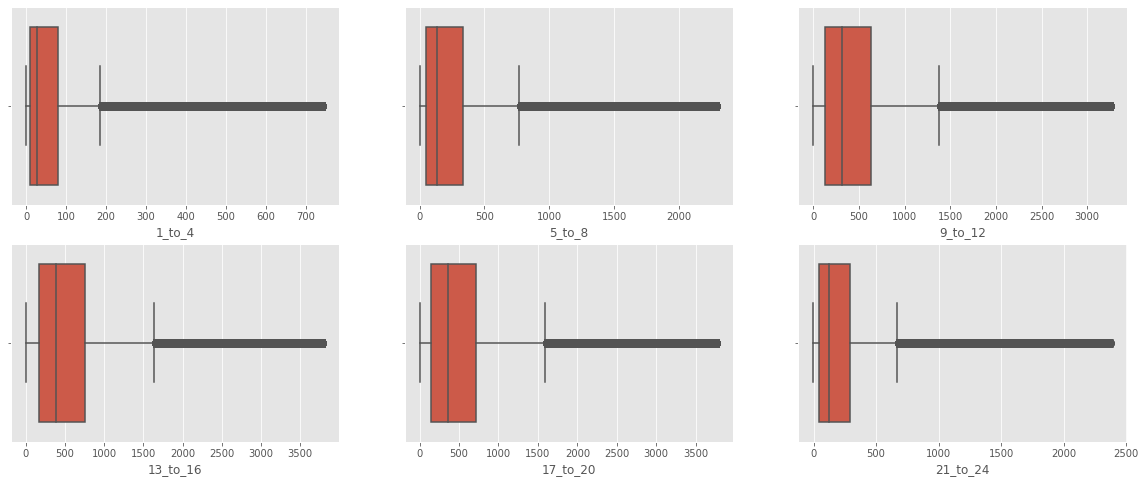

In [19]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
plt.figure(figsize = (20,8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    sns.boxplot(x=traffic_df[timings[i-1]])

We can also see from the below cell output that the** data consistency have been improved in all the time bucket sections** where we have appied the **Z-Score method** and there is nearly no visible difference between the **mean, 75%, and maximum** value of the dataset.

In [20]:
traffic_df.describe()

,day_of_data,day_of_week,direction_of_travel,fips_state_code,lane_of_travel,month_of_data,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24
count,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06
mean,1.572624e+01,4.012449e+00,3.885063e+00,2.985262e+01,1.335427e+00,6.518998e+00,6.073193e+01,2.552298e+02,4.552350e+02,5.455916e+02,5.171385e+02,2.138846e+02
std,8.770013e+00,2.000232e+00,2.281844e+00,1.657622e+01,1.071629e+00,3.456660e+00,8.323963e+01,3.154451e+02,4.602179e+02,5.339154e+02,5.242792e+02,2.468112e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,8.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,4.000000e+00,9.000000e+00,4.700000e+01,1.282500e+02,1.640000e+02,1.435000e+02,4.500000e+01
50%,1.600000e+01,4.000000e+00,5.000000e+00,3.000000e+01,1.000000e+00,7.000000e+00,2.700000e+01,1.355000e+02,3.105000e+02,3.905000e+02,3.545000e+02,1.267500e+02
75%,2.300000e+01,6.000000e+00,5.000000e+00,4.400000e+01,2.000000e+00,1.000000e+01,7.975000e+01,3.357500e+02,6.277500e+02,7.545000e+02,7.207500e+02,2.940000e+02
max,3.100000e+01,7.000000e+00,9.000000e+00,5.600000e+01,9.000000e+00,1.200000e+01,7.455000e+02,2.299750e+03,3.270500e+03,3.805000e+03,3.781250e+03,2.383750e+03


On the basis of below bar plot we can clearly see that The **maximum amout of Traffic occurs on Day 6 i.e saturday ar the hours of 12 to 16.**

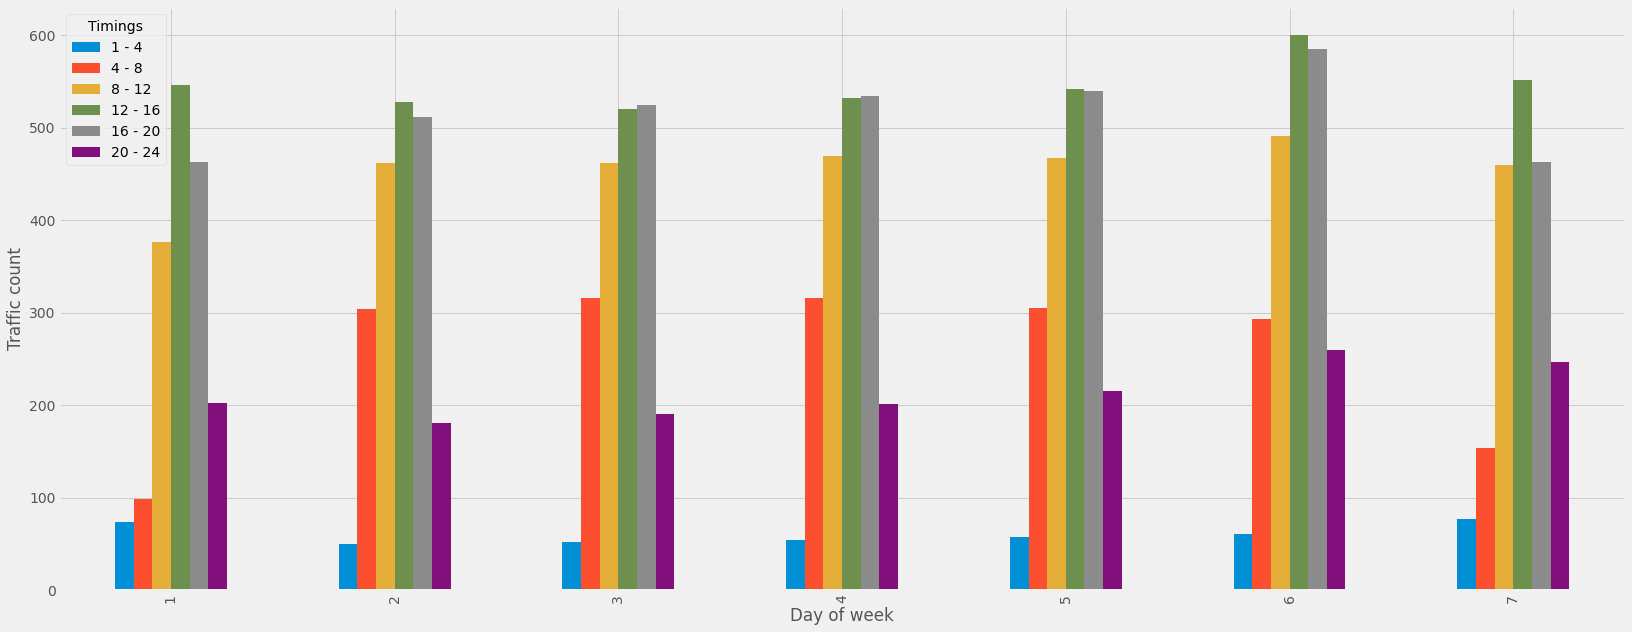

In [23]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
Week_Traffic = pd.DataFrame(traffic_df.groupby(['day_of_week'], axis=0, as_index=False)[timings].mean())

legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
plt.style.use('fivethirtyeight')

Week_Traffic.plot(x='day_of_week', y=timings, kind="bar", figsize=(25,10), xlabel = 'Day of week', ylabel = 'Traffic count')
plt.legend(title='Timings', labels=legends)

In [24]:
# We are renaming the very long direction name in this code cell

traffic_df["direction_of_travel_name"].replace({"North-South or Northeast-Southwest combined (ATR stations only)": "Northeast-Southwest", 
                                                "East-West or Southeast-Northwest combined (ATR stations only)": "Southeast-Northwest"}, inplace=True)

The below code cell helps us to observe the data more vividly and understand it better.

In [25]:
print('functional classification:'.upper())
print(dict(traffic_df['functional_classification'].value_counts()), end = '\n\n')

print('functional classification name:'.upper())
print(dict(traffic_df['functional_classification_name'].value_counts()), end = '\n\n')


print('fips state code:'.upper())
print(dict(traffic_df['fips_state_code'].value_counts()), end = '\n\n')


print('direction of travel:'.upper())
print(dict(traffic_df['direction_of_travel'].value_counts()), end = '\n\n')


print('direction of travel name:'.upper())
print(dict(traffic_df['direction_of_travel_name'].value_counts()), end = '\n\n')

FUNCTIONAL CLASSIFICATION:
{'1U': 1548157, '3R': 1392830, '3U': 1108945, '1R': 992054, '2U': 604921, '4R': 485936, '5R': 319145, '4U': 314540, '5U': 79926, '6R': 37096, '7U': 10688, '7R': 7716}

FUNCTIONAL CLASSIFICATION NAME:
{'Urban: Principal Arterial - Interstate': 1548157, 'Rural: Principal Arterial - Other': 1392830, 'Urban: Principal Arterial - Other': 1108945, 'Rural: Principal Arterial - Interstate': 992054, 'Urban: Principal Arterial - Other Freeways or Expressways': 604921, 'Rural: Minor Arterial': 485936, 'Rural: Major Collector': 319145, 'Urban: Minor Arterial': 314540, 'Urban: Collector': 79926, 'Rural: Minor Collector': 37096, 'Urban: Local System': 10688, 'Rural: Local System': 7716}

FIPS STATE CODE:
{12: 606214, 39: 455679, 51: 451780, 13: 355635, 55: 298451, 53: 266437, 16: 252638, 36: 245816, 40: 202741, 28: 194818, 29: 191551, 1: 183643, 49: 168084, 32: 158457, 15: 151351, 56: 147386, 26: 145656, 19: 144872, 6: 143013, 48: 142145, 30: 126627, 35: 119045, 10: 111765

In The below code cell i have created a function so that i can create a dictionary for the appropriate Feature to match with its Feature name.

Example: Direction and Direction name can be matched, Functional Classification and Functional Classification name can be matched together.

In [26]:
def columnWithName(dict1, dict2):
    ans = {}
    for k, v in dict1.items():
        for k1, v1 in dict2.items():
            if v == v1:
                ans[k] = k1
    return ans

In the below code cell i am making use of the above created function to match the Features with its namings.

In [27]:
functional_classification1 = dict(traffic_df['functional_classification'].value_counts())
functional_classification_name1 = dict(traffic_df['functional_classification_name'].value_counts())
functional_classification_dict = columnWithName(functional_classification1, functional_classification_name1)


direction_of_travel1 = dict(traffic_df['direction_of_travel'].value_counts())
direction_of_travel_name1 = dict(traffic_df['direction_of_travel_name'].value_counts())
direction_of_travel_dict = columnWithName(direction_of_travel1, direction_of_travel_name1)

In the below Bar plot we have created the Graph between **Direction of travel and The traffic count** on Diferrent days across all time Frames.

1. With this we can Easily conclude that **Northeast-Southwest Direction have the maximum amount of traffic specially on Hours 1 to 4, 4 to 8 i.e. early mornings and at Late nights between hours 20 to 24**.

2. We can also conclude that **The traffic on time range 8 to 12 is extremely less irrespective of Direction of travel**.

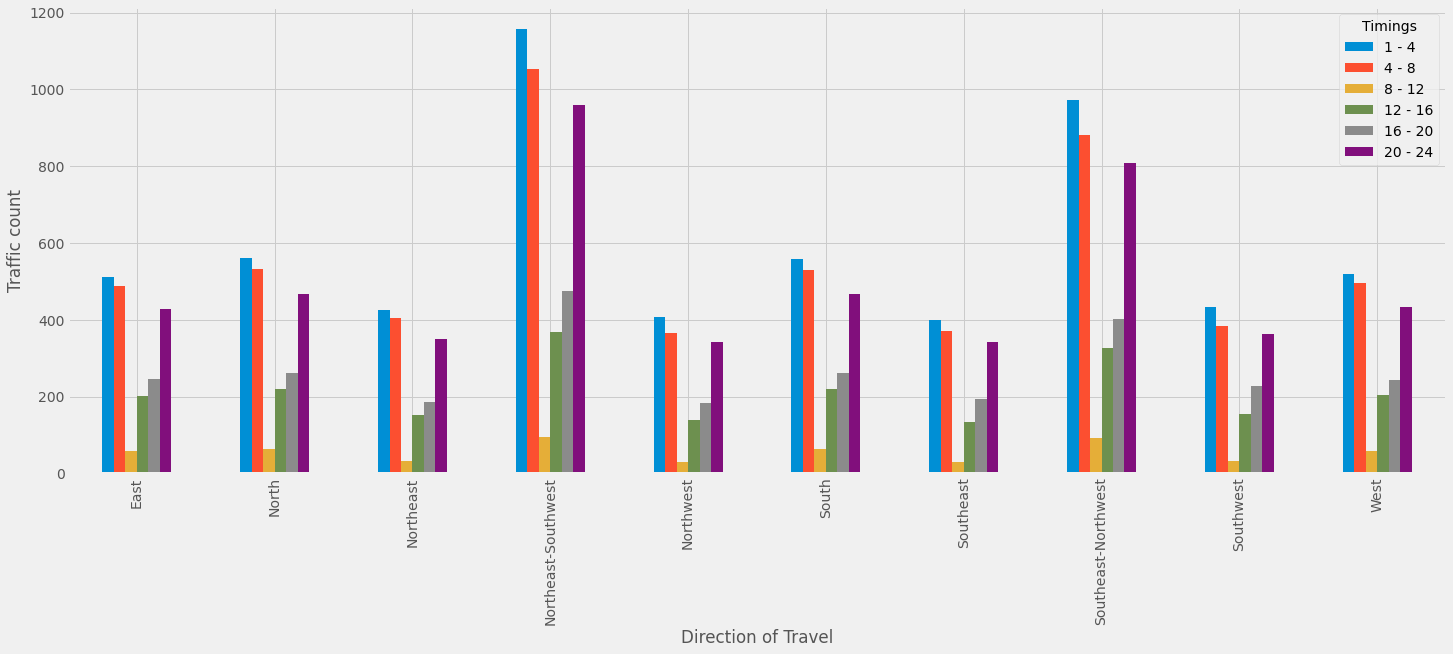

In [32]:
legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
direction_EDA = pd.pivot_table(data=traffic_df, index=['direction_of_travel_name'], values=timings)
direction_EDA.plot(kind='bar', figsize=(22,8), xlabel = 'Direction of Travel', ylabel = 'Traffic count')
plt.style.use('fivethirtyeight')
plt.legend(title='Timings', labels=legends)

We can also conclude on the basis of the below density graph that **highest density of traffic is in Direction number 1 and 5 i.e. North and South across all the times included.**

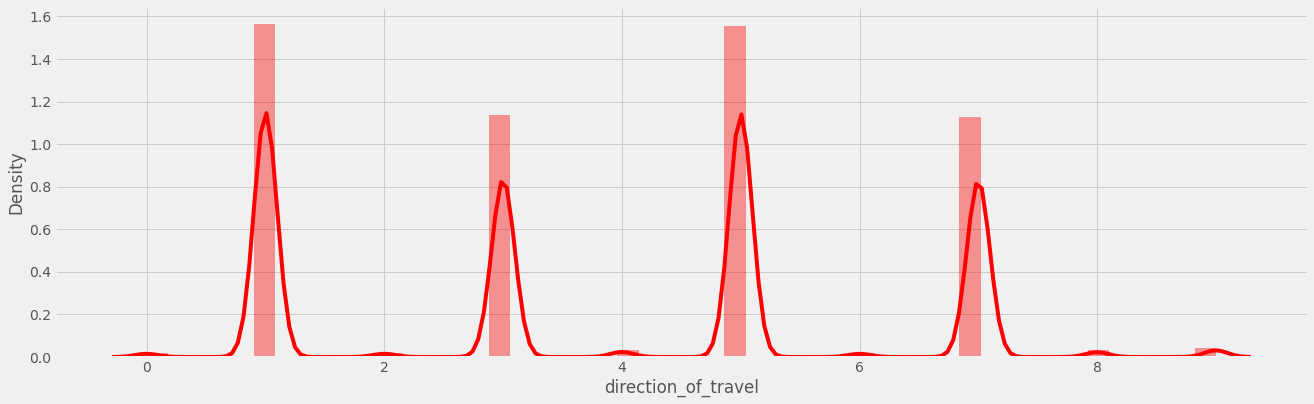

In [29]:
plt.figure(figsize=(20,6))
plt.figure(1)

sns.distplot(traffic_df['direction_of_travel'],color='red')

In the below Graph we have created the Graph between **Lane of travel and The traffic count** on Diferrent days **across all time frames**.

1. With this we can Easily conclude that **Lane number 8 have the maximum amount of traffic specially on Hours 1 to 4 and 4 to 8 i.e Early Mornings**, and the **Least amount of traffic on Lane number 1**.

2. We can also observe that on the **time range of 8 to 12 the traffic is very least irrespective of Lane number**.



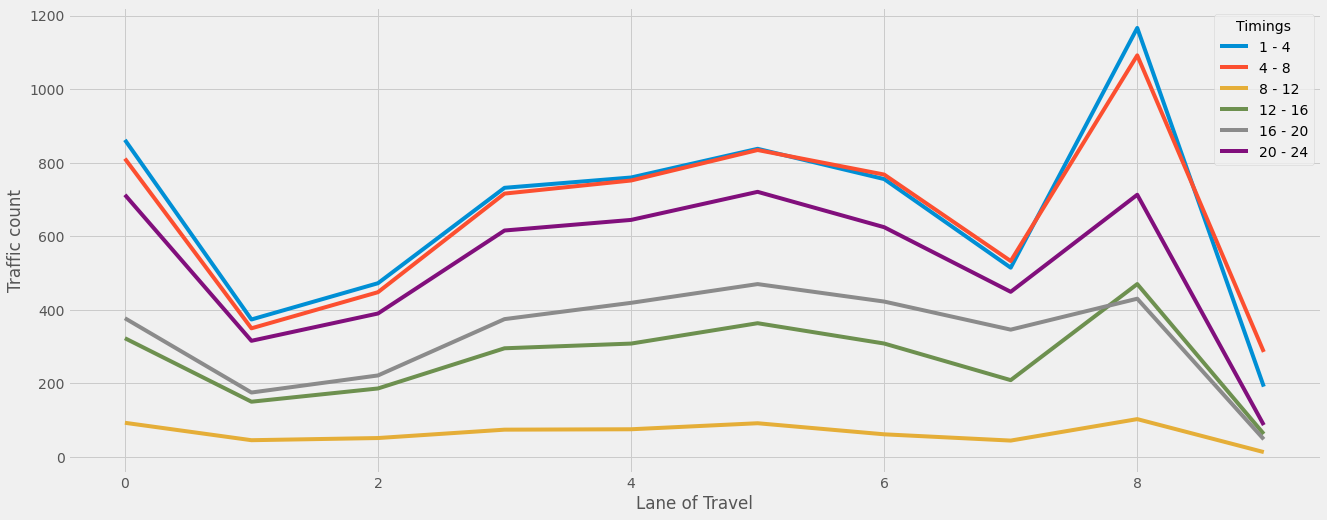

In [37]:
legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
direction_EDA = pd.pivot_table(data=traffic_df, index=['lane_of_travel'], values=timings)
direction_EDA.plot(kind='line', figsize=(20,8), xlabel = 'Lane of Travel', ylabel = 'Traffic count')
plt.style.use('fivethirtyeight')
plt.legend(title='Timings', labels=legends)

In the below Graph we have created the Graph between **Functional Classification and The traffic count** on Diferrent days **across all time frames**.

1. With this we can Easily conclude that **Urban Principal Arterial: Interstate and Other Expressways have the maximum amount of traffic specially on Hours 1 to 4 and 4 to 8 i.e Early Mornings and Late night between hours 20 to 24**, also the **Least amount of traffic on Lane number 1**.

2. We can also observe that on the **time range of 8 to 12 the traffic is very least irrespective of Functional Classification** and on the **Rural Local system we have the least Traffic**.

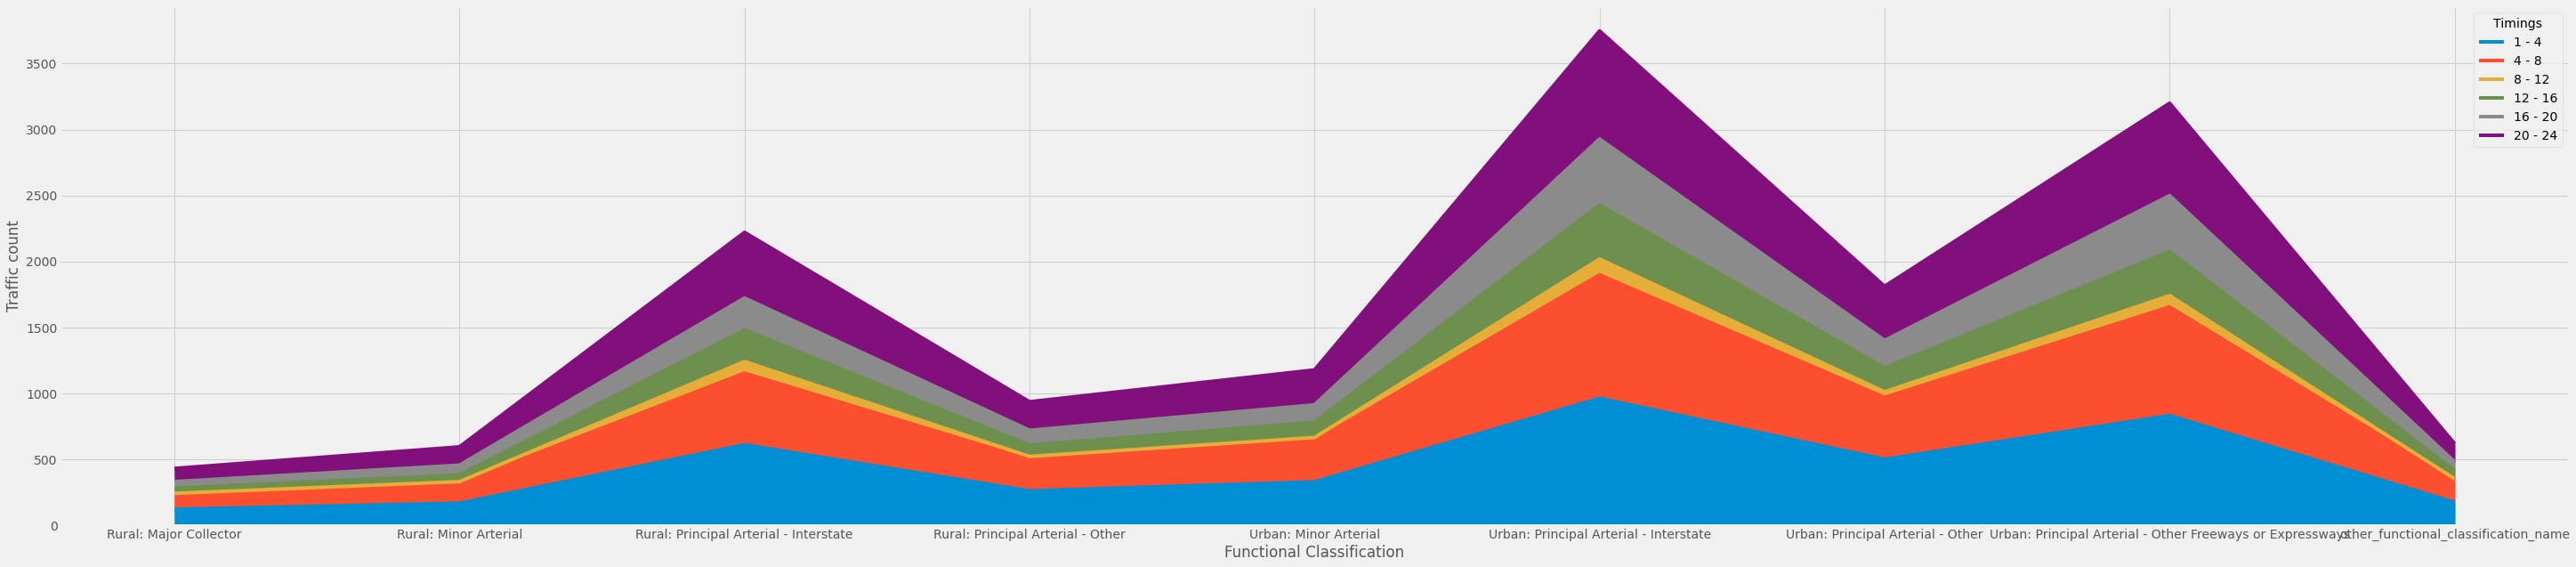

In [52]:
legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
direction_EDA = pd.pivot_table(data=traffic_df, index=['functional_classification_name'], values=timings)
direction_EDA.plot(kind='area', figsize=(45,10), xlabel = 'Functional Classification', ylabel = 'Traffic count')
plt.style.use('fivethirtyeight')
plt.legend(title='Timings', labels=legends)

In [41]:
traffic_df['station_id'].nunique()

5048

In this we are trying to convert station_id into the count of each station_id
since station_id is unique we had to perform this step so as to convert it into a feature.

In [42]:
# def integers(x):
#     ref = dict(traffic_df['station_id'].value_counts())
#     if ref.get(x):
#         return ref[x]

# traffic_df['station_id'] = traffic_df['station_id'].apply(integers)


# I initially tried to to the task using the above mentioned function but it was extremely slow while running and therefore had to look for a better alternative.
# For solving this issue i then used the map function and the proper for which i found the reference at the below mentioned link.
# https://stackoverflow.com/questions/41985566/pandas-replace-dictionary-slowness


station_id_element_count = dict(traffic_df['station_id'].value_counts())
traffic_df['station_id'] = traffic_df['station_id'].map(station_id_element_count.get)

We can now see in the below density graph that the station Id has been converted into the feature and can contribute in the accuracy of the dataset.

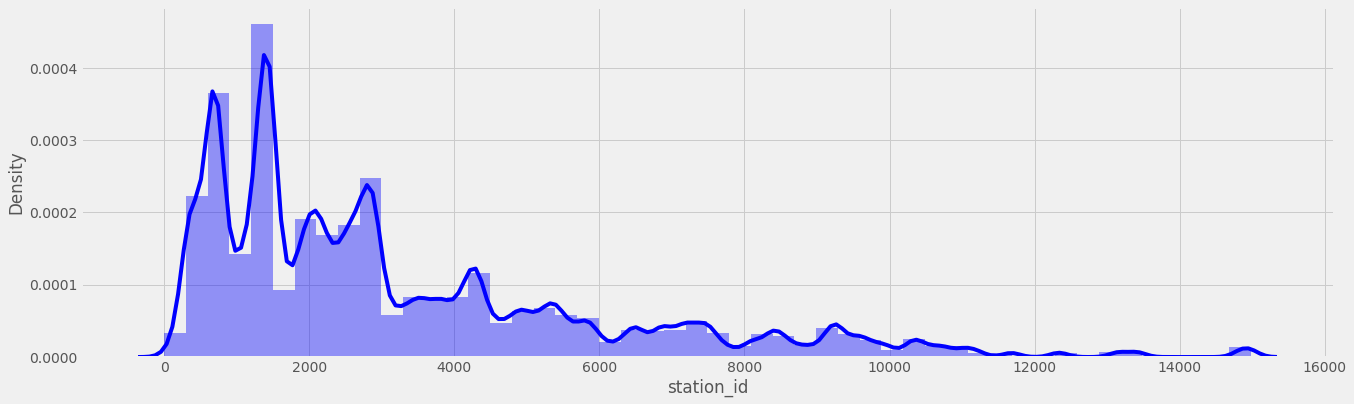

In [43]:
plt.figure(figsize=(20,6))
plt.figure(1)
sns.distplot(traffic_df['station_id'],color='blue')

In the below Code cell we have performed **One Hot Encoding** on the columns **direction_of_travel_name and functional_classification** so that we can convert their unique values into the feature and they can contribute to our final model.

In [44]:
# It is clear that '5U', '6R', '7U', '7R' functional_classification are very much less in number and therefore we can merge them all under one field.
# In the functional_classification column we can see they are categorical ones, so we make new feature out of them.

traffic_df['functional_classification'] = traffic_df['functional_classification'].replace(['5U', '6R', '7U', '7R'], 'other_functional_classifications')
traffic_df['functional_classification_name'] = traffic_df['functional_classification_name'].replace(['Urban: Collector', 
                                                                                                     'Rural: Minor Collector', 
                                                                                                     'Urban: Local System', 
                                                                                                     'Rural: Local System'], 'other_functional_classification_name')

functional_classification_dummy = pd.get_dummies(traffic_df['functional_classification'])

traffic_df = pd.concat([traffic_df, functional_classification_dummy], axis=1)


# In the direction_of_travel_name column we can see they are categorical ones, so we make new feature out of them.

direction_of_travel_name_dummy = pd.get_dummies(traffic_df['direction_of_travel_name'])

traffic_df = pd.concat([traffic_df, direction_of_travel_name_dummy], axis=1)

traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24,1R,1U,2U,3R,3U,4R,4U,5R,other_functional_classifications,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,3542,3.25,95.25,145.25,130.75,106.25,29.75,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,3267,261.25,425.00,1081.25,1457.25,1243.25,736.50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,424,78.00,202.75,755.25,1014.25,769.25,267.75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,597,3.75,20.00,77.50,89.00,45.00,15.00,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
6,2015-09-10,10,5,3,East,19,3U,Urban: Principal Arterial - Other,2,9,3428,38.00,291.75,402.00,518.00,469.00,173.25,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


We can further Solidify our above mentioned proof that the maximum amount of traffic occurs in the Direction of Northeast-Southwest and in time range of 13 to 16 and 17 to 20.

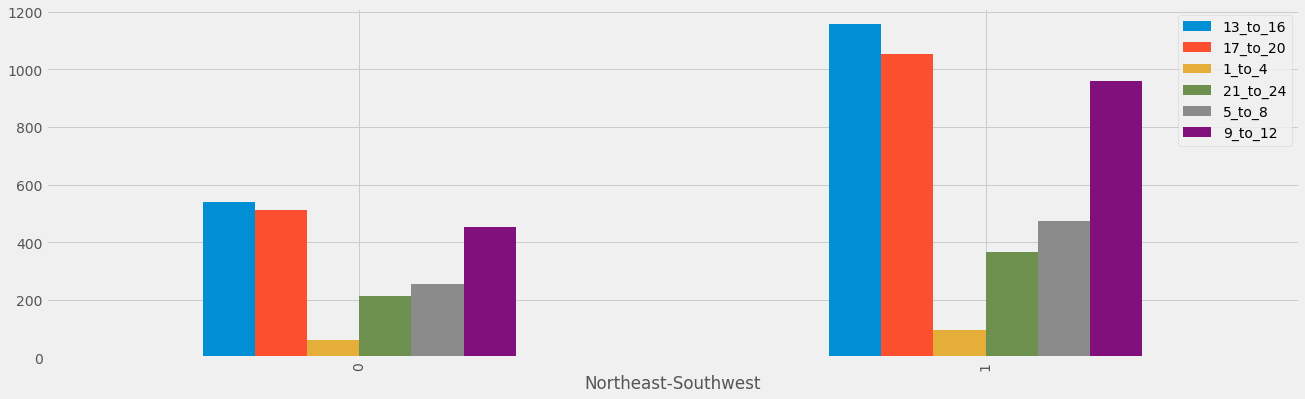

In [54]:
direc = ['North', 'South', 'East', 'West', 'Northeast-Southwest', 'Southeast', 'Northwest', 'Northeast', 'Southeast-Northwest', 'Southwest']
time_rural = pd.pivot_table(traffic_df, index=['Northeast-Southwest'], values =timings)
plt.style.use('fivethirtyeight')
time_rural.plot(kind='bar', figsize=(20, 6));

With the below mentioned Area graph between Station ID and Lane of Travel We can conclude that:

1. The Reason for Maximum Traffic on the Lane number 7 and Lane number 8 was because **There are more number of stationed located on that path** and because of that people Travel more across those lanes.

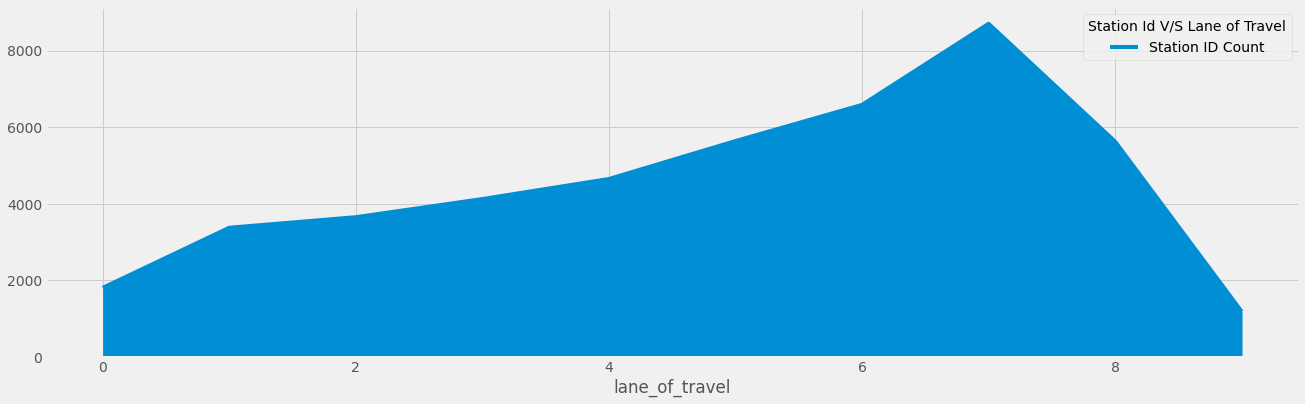

In [55]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
lane_station = pd.pivot_table(traffic_df, index=['lane_of_travel'], values =['station_id'])
plt.style.use('fivethirtyeight')
lane_station.plot(kind='area', figsize=(20, 6));

plt.legend(title='Station Id V/S Lane of Travel', labels=['Station ID Count'])

From the below mentioned Bar Chart between Functional Classification and Lane numbers we can Conclude that:

Most number of people from Rural Areas travel mostly on Outer Lanes (i.e. 5, 6, 7, 8, 9) instead of main Lanes. Infact we can clearly see that There are almost negligible people from Urban Areas travelling in outer lanes except of lane 8 as there as most number of stationes situated in that lane.

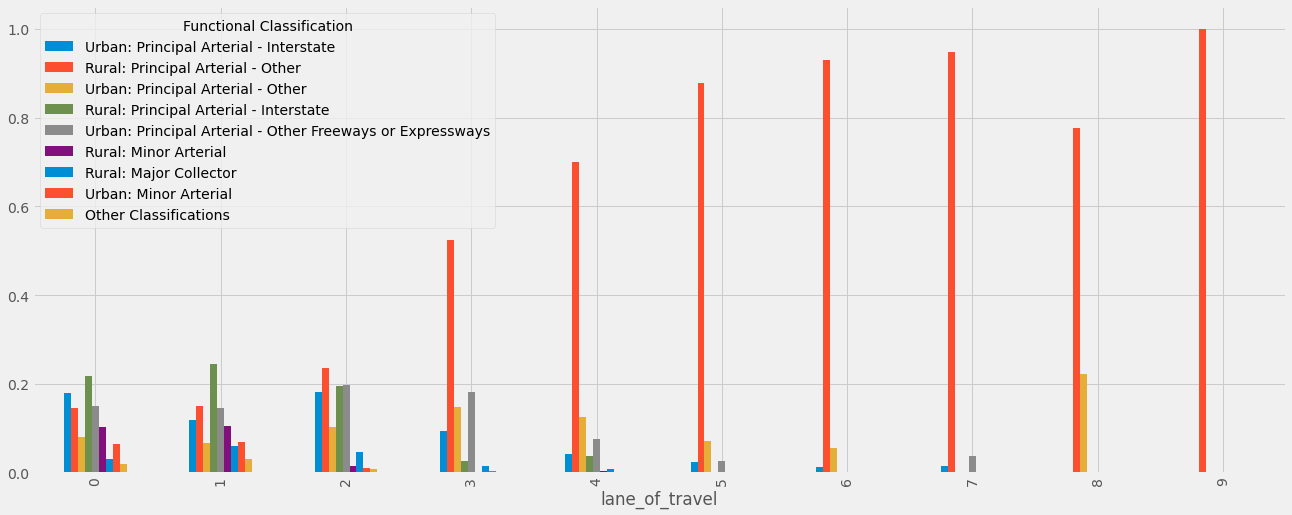

In [56]:
funtional_class = ['1U', '3R', '3U', '1R', '2U', '4R', '5R', '4U', 'other_functional_classifications']
lane_functional = pd.pivot_table(traffic_df, index=['lane_of_travel'], values =funtional_class)
plt.style.use('fivethirtyeight')
lane_functional.plot(kind='bar', figsize=(20, 8));
legends=['Urban: Principal Arterial - Interstate', 'Rural: Principal Arterial - Other', 'Urban: Principal Arterial - Other',
         'Rural: Principal Arterial - Interstate', 'Urban: Principal Arterial - Other Freeways or Expressways', 
         'Rural: Minor Arterial', 'Rural: Major Collector', 'Urban: Minor Arterial', 'Other Classifications']
plt.legend(title='Functional Classification', labels=legends)

We can further solidify our above mentioned argument that Most amount traffic occurs in Urban: Principal Arterial - Interstate Area in hours 13 to 16 and 17 to 20 i.e. in Evening time mostly.

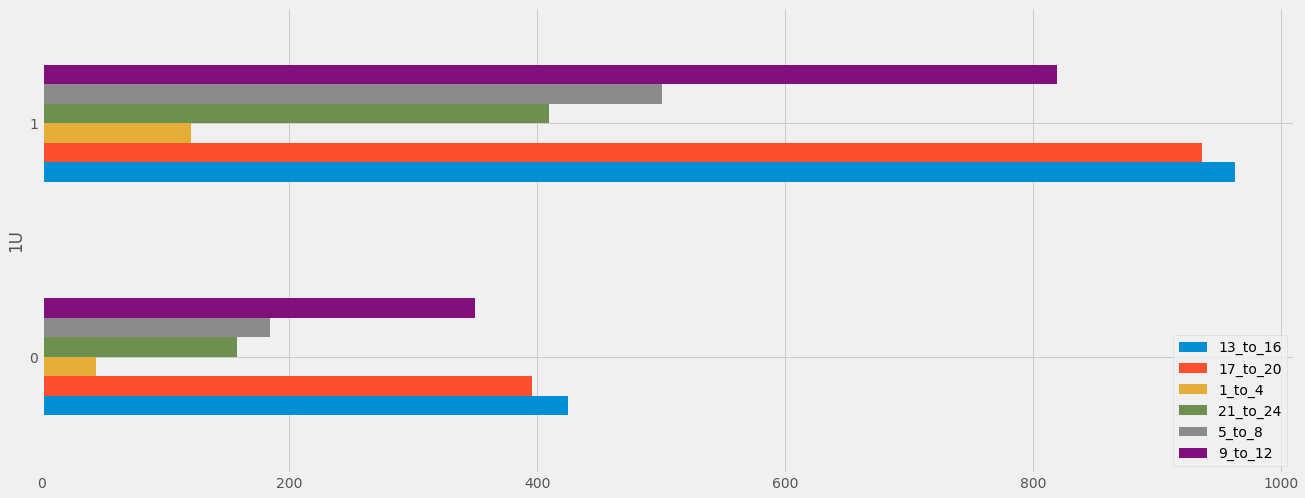

In [57]:
time_rural = pd.pivot_table(traffic_df, index=['1U'], values =timings)
plt.style.use('fivethirtyeight')
time_rural.plot(kind='barh', figsize=(20, 8));

In [58]:
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24,1R,1U,2U,3R,3U,4R,4U,5R,other_functional_classifications,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,3542,3.25,95.25,145.25,130.75,106.25,29.75,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,3267,261.25,425.00,1081.25,1457.25,1243.25,736.50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,424,78.00,202.75,755.25,1014.25,769.25,267.75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,597,3.75,20.00,77.50,89.00,45.00,15.00,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
6,2015-09-10,10,5,3,East,19,3U,Urban: Principal Arterial - Other,2,9,3428,38.00,291.75,402.00,518.00,469.00,173.25,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [59]:
traffic_df.describe()

,day_of_data,day_of_week,direction_of_travel,fips_state_code,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24,1R,1U,2U,3R,3U,4R,4U,5R,other_functional_classifications,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
count,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06
mean,1.572624e+01,4.012449e+00,3.885063e+00,2.985262e+01,1.335427e+00,6.518998e+00,3.242214e+03,6.073193e+01,2.552298e+02,4.552350e+02,5.455916e+02,5.171385e+02,2.138846e+02,1.437352e-01,2.243071e-01,8.764489e-02,2.018023e-01,1.606712e-01,7.040557e-02,4.557260e-02,4.623980e-02,1.962140e-02,2.048695e-01,2.817621e-01,3.734305e-03,7.690286e-03,5.575957e-03,2.799525e-01,5.827190e-03,3.727640e-03,3.690984e-03,2.031696e-01
std,8.770013e+00,2.000232e+00,2.281844e+00,1.657622e+01,1.071629e+00,3.456660e+00,2.796729e+03,8.323963e+01,3.154451e+02,4.602179e+02,5.339154e+02,5.242792e+02,2.468112e+02,3.508211e-01,4.171252e-01,2.827778e-01,4.013454e-01,3.672274e-01,2.558293e-01,2.085563e-01,2.100040e-01,1.386954e-01,4.036063e-01,4.498580e-01,6.099476e-02,8.735643e-02,7.446386e-02,4.489756e-01,7.611330e-02,6.094051e-02,6.064125e-02,4.023577e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,4.000000e+00,1.300000e+03,9.000000e+00,4.700000e+01,1.282500e+02,1.640000e+02,1.435000e+02,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.600000e+01,4.000000e+00,5.000000e+00,3.000000e+01,1.000000e+00,7.000000e+00,2.367000e+03,2.700000e+01,1.355000e+02,3.105000e+02,3.905000e+02,3.545000e+02,1.267500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.300000e+01,6.000000e+00,5.000000e+00,4.400000e+01,2.000000e+00,1.000000e+01,4.355000e+03,7.975000e+01,3.357500e+02,6.277500e+02,7.545000e+02,7.207500e+02,2.940000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.100000e+01,7.000000e+00,9.000000e+00,5.600000e+01,9.000000e+00,1.200000e+01,1.497900e+04,7.455000e+02,2.299750e+03,3.270500e+03,3.805000e+03,3.781250e+03,2.383750e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# **EDA - STATION DATA**

In [60]:
traffic_station_df.head()

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,direction_of_travel,direction_of_travel_name,fips_county_code,fips_state_code,functional_classification,functional_classification_name,hpms_sample_type,lane_of_travel,lane_of_travel_name,latitude,longitude,method_of_data_retrieval,method_of_data_retrieval_name,method_of_traffic_volume_counting,method_of_traffic_volume_counting_name,method_of_truck_weighing,method_of_truck_weighing_name,method_of_vehicle_classification,method_of_vehicle_classification_name,national_highway_system,lane_count,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,primary_purpose_name,record_type,sample_type_for_traffic_volume,sample_type_for_traffic_volume_name,sample_type_for_truck_weight,sample_type_for_truck_weight_name,sample_type_for_vehicle_classification,sample_type_for_vehicle_classification_name,second_type_of_sensor,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,7,West,59,6,2U,Urban: Principal Arterial - Other Freeways or ...,N,4,Other lanes,33.850898,117.814391,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,5,5,0,0,3,091,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,5,South,77,6,3R,Rural: Principal Arterial - Other,N,1,Outside (rightmost) lane,37.874697,121.219590,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,2,2,0,0,3,099,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,1,North,93,6,1R,Rural: Principal Arterial - Interstate,N,2,Other lanes,41.441777,122.435010,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,3,Permanent vehicle classification device,Y,2,2,0,2,1,005,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,H,Station used for Heavy Vehicle Travel Informat...,N,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,5,South,35,49,1U,Urban: Principal Arterial - Interstate,Y,1,Outside (rightmost) lane,40.516500,111.891520,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),4,Portable weigh-in-motion system,3,Permanent vehicle classification device,Y,5,5,5,5,1,15,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,B,Station used for TMG sample and Strategic High...,N,Station not used for Heavy Vehicle Travel Info...,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,7,West,27,34,1U,Urban: Principal Arterial - Interstate,N,4,Other lanes,40.892373,74.484206,2,Automated (telemetry),2,Portable traffic recording device,0,NaN,3,Permanent vehicle classification device,Y,4,4,4,4,1,000080,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,N,Station not used for any of the above,N,Station not used for Heavy Vehicle Travel Info...,NaN,W01136,E. of Franklin Rd Underpass,L,Inductance loop,15,0,95


In [61]:
print('calibration of weighing system:'.upper())
print(dict(traffic_station_df['calibration_of_weighing_system'].value_counts()), end = '\n\n')
print('calibration of weighing system name:'.upper())
print(dict(traffic_station_df['calibration_of_weighing_system_name'].value_counts()), end = '\n\n')

print('algorithm_of_vehicle_classification:'.upper())
print(dict(traffic_station_df['algorithm_of_vehicle_classification'].value_counts()), end = '\n\n')
print('algorithm_of_vehicle_classification_name:'.upper())
print(dict(traffic_station_df['algorithm_of_vehicle_classification_name'].value_counts()), end = '\n\n')

CALIBRATION OF WEIGHING SYSTEM:
{'T': 1744, 'C': 1683, '0': 1455, 'M': 1347, 'Z': 799, 'U': 546, 'A': 439, 'D': 108, 'P': 10, 'B': 9, '2': 8, 'S': 6}

CALIBRATION OF WEIGHING SYSTEM NAME:
{'Test trucks only': 1744, 'Combination of test trucks and trucks from the traffic stream (but not ASTM E1318)': 1683, 'Moving average of the steering axle of 3S2s': 1347, 'Other method': 799, 'Uncalibrated': 546, 'ASTM Standard E1318': 439, 'Other sample of trucks from the traffic stream': 108, 'Subset of ASTM Standard E1318': 9, 'Static calibration': 6}

ALGORITHM_OF_VEHICLE_CLASSIFICATION:
{'F': 7100, 'G': 5148, 'D': 2256, '0': 1220, 'L': 1082, 'K': 548, 'Z': 465, 'M': 420, 'N': 116, 'H': 98, 'C': 42, 'A': 36, '1': 10, 'E': 6}

ALGORITHM_OF_VEHICLE_CLASSIFICATION_NAME:
{'Axle spacing with Scheme F': 7100, 'Axle spacing with Scheme F modified': 5148, 'Vehicle length classification': 2256, 'Axle spacing and vehicle length algorithm': 1082, 'Axle spacing and weight algorithm': 548, 'Other means not sp

In the below code cell we are performing **One Hot Encoding** to convert many useless columns into features.

In [62]:
# It is clear that 'D', 'P', 'B', '2', 'S' calibration_of_weighing_system are very much less in number and therefore we can merge them all under one field.
# In the calibration_of_weighing_system column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['calibration_of_weighing_system'] = traffic_station_df['calibration_of_weighing_system'].replace(['D', 'P', 'B', '2', 'S'], 'other_calibration_of_weighing_system')

calibration_of_weighing_system_dummy = pd.get_dummies(traffic_station_df['calibration_of_weighing_system'])

traffic_station_df = pd.concat([traffic_station_df, calibration_of_weighing_system_dummy], axis=1)


# It is clear that 'Z', 'M', 'N', 'H', 'C', 'A', '1', 'E' algorithm_of_vehicle_classification are very much less in number and therefore we can merge them all under one field.
# In the algorithm_of_vehicle_classification column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['algorithm_of_vehicle_classification'] = traffic_station_df['algorithm_of_vehicle_classification'].replace(['Z', 'M', 'N', 'H', 'C', 'A', '1', 'E'], 'other_algorithm_of_vehicle_classification')
traffic_station_df['algorithm_of_vehicle_classification'] = traffic_station_df['algorithm_of_vehicle_classification'].replace(['0'], 'A_0')

algorithm_of_vehicle_classification_dummy = pd.get_dummies(traffic_station_df['algorithm_of_vehicle_classification'])

traffic_station_df = pd.concat([traffic_station_df, algorithm_of_vehicle_classification_dummy], axis=1)

# Renaming the very long column name.

traffic_station_df["direction_of_travel_name"].replace({"North-South or Northeast-Southwest combined (ATR stations only)": "Northeast-Southwest", 
                                                "East-West or Southeast-Northwest combined (ATR stations only)": "Southeast-Northwest"}, inplace=True)

# In the direction_of_travel_name column we can see they are categorical ones, so we make new feature out of them.

direction_of_travel_name_dummy1 = pd.get_dummies(traffic_station_df['direction_of_travel_name'])

traffic_station_df = pd.concat([traffic_station_df, direction_of_travel_name_dummy1], axis=1)


# It is clear that '5U', '6R', '7U', '7R' functional_classification are very much less in number and therefore we can merge them all under one field.
# In the functional_classification column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['functional_classification'] = traffic_station_df['functional_classification'].replace(['5U', '6R', '7U', '7R'], 'other_functional_classifications')
traffic_station_df['functional_classification_name'] = traffic_station_df['functional_classification_name'].replace(['Urban: Collector', 
                                                                                                     'Rural: Minor Collector', 
                                                                                                     'Urban: Local System', 
                                                                                                     'Rural: Local System'], 'other_functional_classification_name')

functional_classification_dummy1 = pd.get_dummies(traffic_station_df['functional_classification'])

traffic_station_df = pd.concat([traffic_station_df, functional_classification_dummy1], axis=1)


# In the lane_of_travel_name column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['lane_of_travel_name'] = traffic_station_df['lane_of_travel_name'].replace(['Outside (rightmost) lane'], 'Outside_rightmost_lane')
traffic_station_df['lane_of_travel_name'] = traffic_station_df['lane_of_travel_name'].replace(['Data with lanes combined'], 'Data_with_lanes_combined')
traffic_station_df['lane_of_travel_name'] = traffic_station_df['lane_of_travel_name'].replace(['Other lanes'], 'Other_lanes')

lane_of_travel_name_dummy = pd.get_dummies(traffic_station_df['lane_of_travel_name'])

traffic_station_df = pd.concat([traffic_station_df, lane_of_travel_name_dummy], axis=1)


# In the method_of_traffic_volume_counting_name column we can see they are categorical ones, so we make new feature out of them.


traffic_station_df.replace({'method_of_traffic_volume_counting_name' : { 'Permanent automatic traffic recorder (ATR)' : 'TVC_Automatic', 
                                                               'Portable traffic recording device' : 'TVC_Portable',
                                                                'Human observation (manual)': 'TVC_Manual'}}, inplace=True)

method_of_traffic_volume_counting_name_dummy = pd.get_dummies(traffic_station_df['method_of_traffic_volume_counting_name'])

traffic_station_df = pd.concat([traffic_station_df, method_of_traffic_volume_counting_name_dummy], axis=1)

traffic_station_df.head()

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,direction_of_travel,direction_of_travel_name,fips_county_code,fips_state_code,functional_classification,functional_classification_name,hpms_sample_type,lane_of_travel,lane_of_travel_name,latitude,longitude,method_of_data_retrieval,method_of_data_retrieval_name,method_of_traffic_volume_counting,method_of_traffic_volume_counting_name,method_of_truck_weighing,method_of_truck_weighing_name,method_of_vehicle_classification,method_of_vehicle_classification_name,national_highway_system,lane_count,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,primary_purpose_name,record_type,sample_type_for_traffic_volume,sample_type_for_traffic_volume_name,sample_type_for_truck_weight,sample_type_for_truck_weight_name,...,0,A,C,M,T,U,Z,other_calibration_of_weighing_system,A_0,D,F,G,K,L,other_algorithm_of_vehicle_classification,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West,1R,1U,2U,3R,3U,4R,4U,5R,other_functional_classifications,Data_with_lanes_combined,Other_lanes,Outside_rightmost_lane,TVC_Automatic,TVC_Manual,TVC_Portable
0,NaN,NaN,NaN,NaN,13,3,7,West,59,6,2U,Urban: Principal Arterial - Other Freeways or ...,N,4,Other_lanes,33.850898,117.814391,2,Automated (telemetry),3,TVC_Automatic,0,NaN,0,NaN,Y,5,5,0,0,3,091,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
1,NaN,NaN,NaN,NaN,13,3,5,South,77,6,3R,Rural: Principal Arterial - Other,N,1,Outside_rightmost_lane,37.874697,121.219590,2,Automated (telemetry),3,TVC_Automatic,0,NaN,0,NaN,Y,2,2,0,0,3,099,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,1,North,93,6,1R,Rural: Principal Arterial - Interstate,N,2,Other_lanes,41.441777,122.435010,2,Automated (telemetry),3,TVC_Automatic,0,NaN,3,Permanent vehicle classification device,Y,2,2,0,2,1,005,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,5,South,35,49,1U,Urban: Principal Arterial - Interstate,Y,1,Outside_rightmost_lane,40.516500,111.891520,2,Automated (telemetry),3,TVC_Automatic,4,Portable weigh-in-motion system,3,Permanent vehicle classification device,Y,5,5,5,5,1,15,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,B,Station used for TMG sample and Strategic High...,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,7,West,27,34,1U,Urban: Principal Arterial - Interstate,N,4,Other_lanes,40.892373,74.484206,2,Automated (telemetry),2,TVC_Portable,0,NaN,3,Permanent vehicle classification device,Y,4,4,4,4,1,000080,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,N,Station not used for any of the above,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In the below code cell we are converting the columns which contains only 2 values into vinary values on 1 and 0 so that they can be machine readable and can be used as a feature.

In [63]:
traffic_station_df.replace({'sample_type_for_traffic_volume_name' : {'Station used for Traffic Volume Trends': 1, 
                                                                     'Station not used for Traffic Volume Trends': 0}}, inplace=True)

traffic_station_df.replace({'sample_type_for_vehicle_classification_name' : {'Station used for Heavy Vehicle Travel Information System': 1, 
                                                                             'Station not used for Heavy Vehicle Travel Information System': 0}}, inplace=True)

traffic_station_df.replace({'method_of_data_retrieval_name' : { 'Automated (telemetry)' : 1, 'Not automated (manual)' : 0}}, inplace=True)

traffic_station_df.replace({'hpms_sample_type' : { 'N' : 1, 'Y' : 0}}, inplace=True)

traffic_station_df.replace({'national_highway_system' : { 'N' : 0, 'Y' : 1}}, inplace=True)

Here we are converting all the columns which contains many unique values into the counts of each value so that they all can be used as the feature and contribute into our model accuracy.

In [64]:
year_station_established_count = dict(traffic_station_df['year_station_established'].value_counts())
traffic_station_df['year_station_established'] = traffic_station_df['year_station_established'].map(year_station_established_count.get)

year_station_discontinued_count = dict(traffic_station_df['year_station_discontinued'].value_counts())
traffic_station_df['year_station_discontinued'] = traffic_station_df['year_station_discontinued'].map(year_station_discontinued_count.get)

station_id_element_count1 = dict(traffic_station_df['station_id'].value_counts())
traffic_station_df['station_id'] = traffic_station_df['station_id'].map(station_id_element_count1.get)

previous_station_id_count = dict(traffic_station_df['previous_station_id'].value_counts())
traffic_station_df['previous_station_id'] = traffic_station_df['previous_station_id'].map(previous_station_id_count.get)

posted_signed_route_number_count = dict(traffic_station_df['posted_signed_route_number'].value_counts())
traffic_station_df['posted_signed_route_number'] = traffic_station_df['posted_signed_route_number'].map(posted_signed_route_number_count.get)

Here we are dropping all the useless column and the columns we have already converted into the features.

In [65]:
traffic_station_df.drop(['calibration_of_weighing_system', 'calibration_of_weighing_system_name', 
                         'algorithm_of_vehicle_classification', 'algorithm_of_vehicle_classification_name',
                        'direction_of_travel_name', 'functional_classification','functional_classification_name', 'lane_of_travel_name',
                        'method_of_traffic_volume_counting_name', 'year_of_data', 'station_location', 'method_of_truck_weighing_name',
                        'record_type', 'sample_type_for_traffic_volume', 'sample_type_for_truck_weight_name',
                        'sample_type_for_truck_weight', 'sample_type_for_vehicle_classification', 'type_of_sensor_name',
                        'type_of_sensor', 'second_type_of_sensor', 'primary_purpose', 'primary_purpose_name', 
                        'method_of_vehicle_classification_name'], axis = 1, inplace=True)
traffic_station_df.reset_index(inplace=True, drop=True)

# **Modelling**

In [ ]:
traffic_df_m = traffic_df.drop(['date', 'direction_of_travel_name', 'functional_classification_name', 'functional_classification', 'fips_state_code'], axis = 1)

In [ ]:
traffic_df_m.reset_index(inplace=True, drop=True)
traffic_df_m.head()

,day_of_data,day_of_week,direction_of_travel,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24,1R,1U,2U,3R,3U,4R,4U,5R,other_functional_classifications,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
0,7,3,1,1,4,3542,3.25,95.25,145.25,130.75,106.25,29.75,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,26,7,7,2,9,3267,261.25,425.00,1081.25,1457.25,1243.25,736.50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,26,1,5,1,4,424,78.00,202.75,755.25,1014.25,769.25,267.75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,23,7,3,0,5,597,3.75,20.00,77.50,89.00,45.00,15.00,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10,5,3,2,9,3428,38.00,291.75,402.00,518.00,469.00,173.25,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Setting up our X and Y axis i.e. input(X axis) and output(Y axis) i.e. target value.
# Splitting out training data into new Train data and Validation data.

y = traffic_df_m['lane_of_travel']
X_train = traffic_df_m.drop(['lane_of_travel'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_train, y, test_size = 0.2, random_state=0)

In [ ]:
# Defining Lists to Store in the Results and Names of Algorithms
MSE_Score = []
R2_Score = []
Algorithm = []

## **Random Forest Model**

In [ ]:
# Creating the RandomForest model with number of trees = 500 to get better performance.
Algorithm.append('Random Forest Regressor')
RF_model = RandomForestRegressor(n_estimators=10)
# Fit the model with our training data.
RF_model.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# X_test= Xtest.drop(['lane_of_travel'], axis = 1)
Output = RF_model.predict(Xtest)

In [ ]:
accuracy_train = round(RF_model.score(Xtest, ytest)*100,2)
print(round(accuracy_train,2),'%')

95.25 %


In [ ]:
# Appending the Scores For Visualisation at a Later Part
MSE_Score.append(mean_squared_error(ytest, Output))
R2_Score.append(r2_score(ytest, Output))

In [ ]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
time_ranges = [(0,4), (5,8), (9, 12), (13, 16), (17, 20), (21,24)]
print("Please input your desired travelling time in 24-Hours format (example: 11, 12, 13, 14) : ")
user_time  = int(input())
usertime = 0
for i in range(len(time_ranges)):
  start, end = time_ranges[i]
  if start <= user_time <= end:
    usertime = timings[i]
    break

Please input your desired travelling time in 24-Hours format (example: 11, 12, 13, 14) : 
8


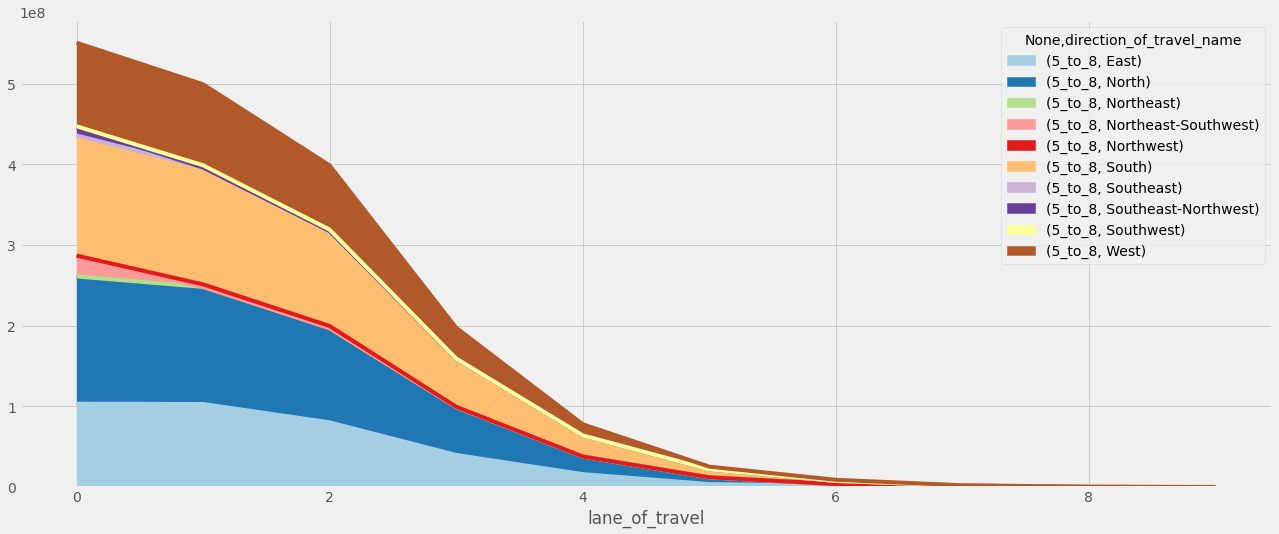

In [ ]:
table = pd.pivot_table(traffic_df, values=[usertime], index=['lane_of_travel'],
                    columns=['direction_of_travel_name'], aggfunc=np.sum, fill_value=0)
plt.style.use('fivethirtyeight')
table.plot(kind='area', figsize=(20, 8), colormap='Paired');

## **Score Card of the Models' Performances**

In [ ]:
# Just Combining the Lists into a DataFrame for a Better Visualisation
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])
Comparison

,Algorithm,MSE_Score,R2_Score
0,Random Forest Regressor,0.054548,0.95246
